## Spectral grid fitting for the SALT spectra

CARMENES spectra:

http://carmenes.cab.inta-csic.es/gto/jsp/reinersetal2018.jsp

In [218]:
from scipy.signal import correlate
from scipy import interpolate

import numpy as np
import pandas as pd

import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

import matplotlib.pyplot as plt

from astropy.io import fits

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

valdir = '/home/ekaterina/Documents/002_writing/multiperiod-flares-draft/values/'
figdir = '/home/ekaterina/Documents/002_writing/multiperiod-flares-draft/figures/'

In [2]:
from eniric import broaden

from funcs.xcorr import correlate_maxlag, correlate_template, get_lags

/home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/__init__.py:23: UserWarning: Using the default config.yaml file located at /home/ekaterina/Documents/000_envs/forallpurposes/lib/python3.6/site-packages/eniric/config.yaml. This is likely NOT what you want and you will not be able to change any of the config values. Please use config.copy_file(<path>) to copy a version of the default config for your own project.
  UserWarning,


# Get spectra

In [3]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"

# SALT1 and SALT2

sp1 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
# mask an emission line that is only seen in SALT but not in CARMENES
sp1.loc[((sp1["lambd"]>7949.2) & (sp1["lambd"]<7949.8)), "flux"] = np.nan
sp1 = sp1.dropna(how="any")

sp2 = pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
# mask an emission line that is only seen in SALT but not in CARMENES
sp2.loc[((sp2["lambd"]>7949.2) & (sp2["lambd"]<7949.8)), "flux"] = np.nan
sp2 = sp2.dropna(how="any")



# Non-rotating spectra 

carms = {"CN Leo":["M6","carmenes_cnleo_vis.fits",3.05,"cnleo"],
         "LP 731-058":["M6.5","carmenes_lp731_m65_vis.fits",1.05,"lp731"],
        "Teegarden's Star":["M7","carmenes_teegarden_vis.fits",3.45,"teega"],
        "lsmp":["M5.5","carmenes_nltt_vis.fits",0,"lspm"]}#carmenes_17kms_vis.fits,

for s, l in carms.items():
    hdu = fits.open(f"{dirr}/carmenes/{l[1]}")
    lambd = hdu[4].data.flatten().byteswap().newbyteorder() - l[2]
    flux = hdu[1].data.flatten().byteswap().newbyteorder()
    sp4 = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
    sp4 = sp4.dropna(how="any")
    l.append(sp4)

# carms["settl"]=["2700K", "setll",0,'settl',
#                 pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])]
    
salt = {"TIC 44984200":[sp1,"r"],
        "TIC 277539431":[sp2,"b"],
        "LSPM":[carms["lsmp"][4],"c"]}    
carms.keys()

dict_keys(['CN Leo', 'LP 731-058', "Teegarden's Star", 'lsmp'])

# Pick spectral regions

In [4]:
lines = [(7938,7955,7948),
         (6556,6570,6562.79),
#          (7695,7705,7699),#not sensitive
#          (6640,6655,6655), #mostly noise
#          (6670,6685,6685),
#          (6800,6820,6820),
#          (7052,7060,7070),#okay one
#          (7080,7100,7090),
#          (7120,7140,7120),
         
         ]
line = lines[0]

Text(0, 0.5, 'norm. flux')

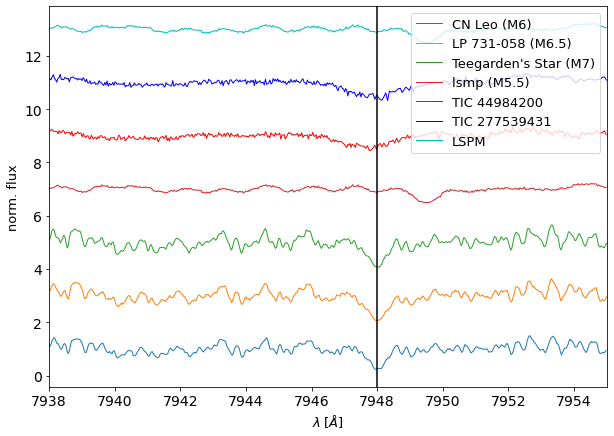

In [5]:
plt.figure(figsize=(10,7))

    
off = 0
wavmin, wavmax = line[0], line[1]
for key, l in carms.items():
    sp = l[4]
    wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    plt.plot(wav,mflux/np.median(mflux)+off , linewidth=1, label=f"{key} ({l[0]})")
    off +=2
    
for l,spc in salt.items():
    
    sp, c = spc
    
    wav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    mflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    plt.plot(wav,mflux/np.median(mflux)+off , linewidth=1, label=f"{l}", c=c)
    off +=2

plt.axvline(line[2], c="k")

plt.xlim(wavmin, wavmax)
#plt.ylim(-100,1e5)
#plt.ylim(0,4.6)
plt.legend(fontsize=13)
plt.xlabel(r"$\lambda\;[\AA]$", fontsize=13)
plt.ylabel(r"norm. flux", fontsize=13)
#plt.savefig(f"../plots/vsini/{tstamp}_salt12_{line[2]:.0f}.png", dpi=300);

In [6]:
#'CN Leo', 'LP 731-058', "Teegarden's Star"
key =  'CN Leo'
model = carms[key][4]
wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values 
mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"flux"].values

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [52]:
vsinis = np.arange(33,38,.25)
vsinis

array([33.  , 33.25, 33.5 , 33.75, 34.  , 34.25, 34.5 , 34.75, 35.  ,
       35.25, 35.5 , 35.75, 36.  , 36.25, 36.5 , 36.75, 37.  , 37.25,
       37.5 , 37.75])

In [53]:
#specs = pd.DataFrame({"wav":wav})

for vsini in vsinis:
    specs[vsini] = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini)


100%|██████████| 510/510 [00:00<00:00, 775.94it/s]


In [12]:
specs.columns.values

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', 30.0, 30.5, 31.0, 31.5, 32.0, 32.5, 33.0, 33.5,
       34.0, 34.5, 35.0, 35.5, 36.0, 36.5, 37.0, 37.5, 38.0, 38.5, 39.0,
       39.5, 40.0, 40.5, 41.0, 41.5], dtype=object)

In [118]:
grid = f"{wavmin}_{wavmax}_{carms[key][3]}.csv"
#specs.to_csv(f"../../data/eniric/{grid}")
specs = pd.read_csv(f"../../data/eniric/{grid}")
specs = specs.set_index("wav")
specs

,0,1,2,3,4,5,6,7,8,9,...,33.25,33.75,34.25,34.75,35.25,35.75,36.25,36.75,37.25,37.75
wav,,,,,,,,,,,,,,,,,,,,,
7938.001362,0.038129,0.038129,0.038230,0.038759,0.039157,0.039514,0.039696,0.039718,0.039613,0.039453,...,0.035471,0.035500,0.035553,0.035589,0.035632,0.035672,0.035704,0.035746,0.035779,0.035811
7938.035777,0.035516,0.035516,0.037165,0.038315,0.039139,0.039918,0.040470,0.040563,0.040435,0.040223,...,0.035623,0.035646,0.035697,0.035730,0.035771,0.035811,0.035843,0.035881,0.035911,0.035938
7938.070188,0.038695,0.038695,0.038949,0.039561,0.040070,0.040593,0.040948,0.040988,0.040868,0.040689,...,0.035811,0.035825,0.035863,0.035886,0.035918,0.035951,0.035976,0.036005,0.036030,0.036046
7938.104594,0.042766,0.042766,0.042339,0.041947,0.041671,0.041425,0.041200,0.041085,0.040931,0.040758,...,0.036034,0.036035,0.036053,0.036061,0.036075,0.036091,0.036103,0.036114,0.036125,0.036127
7938.138997,0.045337,0.045337,0.044737,0.043777,0.042959,0.042087,0.041430,0.040994,0.040671,0.040427,...,0.036281,0.036272,0.036260,0.036250,0.036239,0.036231,0.036223,0.036210,0.036203,0.036189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7954.841168,0.027344,0.027344,0.027457,0.027459,0.027709,0.028153,0.028699,0.029503,0.030181,0.030668,...,0.034193,0.034267,0.034348,0.034424,0.034489,0.034563,0.034624,0.034686,0.034744,0.034793
7954.873435,0.028363,0.028363,0.027794,0.027701,0.027827,0.028083,0.028401,0.029018,0.029520,0.029897,...,0.034277,0.034342,0.034407,0.034468,0.034520,0.034580,0.034630,0.034680,0.034728,0.034772
7954.905699,0.027439,0.027439,0.027996,0.028265,0.028451,0.028594,0.028711,0.028815,0.028988,0.029192,...,0.034361,0.034415,0.034464,0.034511,0.034552,0.034598,0.034637,0.034686,0.034730,0.034775


In [17]:
from astropy.constants import c
lagunit = (np.mean(np.diff(wav)) / line[2] * c).to("km/s")
lagunit

<Quantity 1.25746961 km / s>

TIC 44984200
TIC 277539431
LSPM


Text(0, 0.5, 'cross-correlation function')

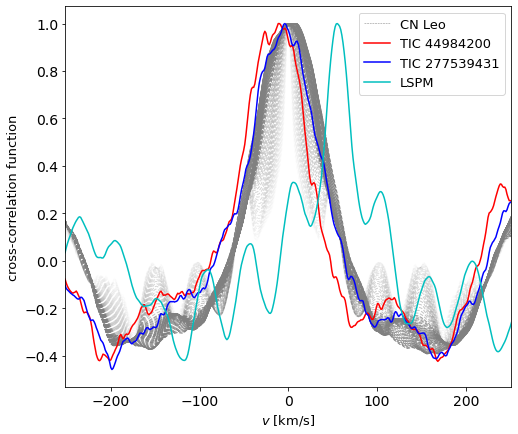

In [55]:
corrf = pd.DataFrame()
plt.figure(figsize=(8,7))
N = len(mflux)
maxlag = 200
start = N // 2
b = mflux
for vsini in specs.columns.values:

    a = specs[vsini]
    cc1 = correlate_maxlag(a, b, maxlag)
    v = get_lags(cc1)*lagunit
    plt.plot(v, cc1/np.max(cc1),c="grey", 
             alpha = float(vsini)/60, linewidth=1,
             linestyle="dashed")
    corrf[vsini] = cc1

plt.plot(v, cc1/np.max(cc1),c="grey", 
             alpha = 1., linewidth=0.5,
             linestyle="dashed",label=f"{key}")    
    
corrsp = {}    

for lab, spc in salt.items():    
    sp, c = spc
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
    sfluxinterp = f(wav)
    sfluxinterp = sfluxinterp / np.median(sfluxinterp)
    cc1 = correlate_maxlag(sfluxinterp, b, maxlag)
    v = get_lags(cc1)*lagunit
    plt.plot(v, cc1/np.max(cc1), label=f"{lab}", c=c)
    print(lab)
    corrsp[lab] = cc1
    
plt.xlim((-maxlag*lagunit).value, (maxlag*lagunit).value)
plt.legend(fontsize=13)
plt.xlabel(r"$v$ [km/s]", fontsize=13)
plt.ylabel(r"cross-correlation function", fontsize=13)
#plt.savefig(f"../plots/vsini/{tstamp}_{key}_salt12_crosscorr.png", dpi=300);

In [175]:
salt

{'TIC 44984200': [              lambd      flux  flux_err
  0       3800.778493  0.000000  0.000000
  1       3800.928310  0.000000  0.000000
  2       3801.077975  0.000000  0.000000
  3       3801.167701  0.000000  0.000000
  4       3801.197598  0.000000  0.000000
  ...             ...       ...       ...
  116069  8709.527901  0.004041  0.000001
  116070  8709.558220  0.003687  0.000001
  116071  8709.588532  0.003841  0.000001
  116072  8709.618836  0.003655  0.000001
  116073  8709.649133  0.004518  0.000001
  
  [116063 rows x 3 columns],
  'r'],
 'TIC 277539431': [              lambd      flux  flux_err
  0       3815.428078  0.000000  0.000000
  1       3815.508939  0.000000  0.000000
  2       3815.562817  0.000000  0.000000
  3       3815.589748  0.000000  0.000000
  4       3815.616673  0.000000  0.000000
  ...             ...       ...       ...
  117461  8709.713681  0.004294  0.000001
  117462  8709.744001  0.004415  0.000001
  117463  8709.774313  0.004369  0.000001
  1

CN Leo TIC 44984200 34.45741859919977 1.2069965490955508
CN Leo TIC 277539431 39.16668962054652 1.79135142048913
LP 731-058 TIC 44984200 34.720099121810634 1.6319623667271266
LP 731-058 TIC 277539431 38.95421634483717 1.945582459379565
Teegarden's Star TIC 44984200 35.34897673545768 1.368563039378495
Teegarden's Star TIC 277539431 37.734001816380925 1.633602122250083


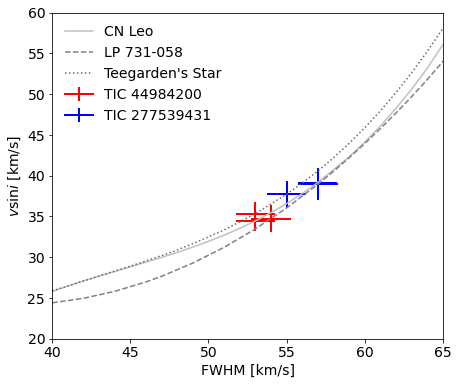

In [246]:
res = {}
plt.figure(figsize=(7,6))
for key, col, ls in [('CN Leo',"silver", "solid"), 
                     ('LP 731-058',"grey","dashed"), 
                     ("Teegarden's Star", "dimgrey", "dotted")]:
    
    res[key] = {}
    
    model = carms[key][4]
    wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax), "lambd"].values 
    mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax), "flux"].values

    from astropy.constants import c
    lagunit = (np.mean(np.diff(wav)) / line[2] * c).to("km/s")


    grid = f"{wavmin}_{wavmax}_{carms[key][3]}.csv"
    specs = pd.read_csv(f"../../data/eniric/{grid}")
    specs = specs.set_index("wav")


    corrf = pd.DataFrame()
    N = len(mflux)
    maxlag = 200
    start = N // 2
    b = mflux
    for vsini in specs.columns.values:

        a = specs[vsini]
        cc1 = correlate_maxlag(a, b, maxlag)
        corrf[vsini] = cc1


    corrsp = {}    

    for lab, spc in salt.items():    
        sp, c = spc
        sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
        swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
        f = interpolate.interp1d(swav, sflux, fill_value="extrapolate")
        sfluxinterp = f(wav)
        sfluxinterp = sfluxinterp / np.median(sfluxinterp)
        cc1 = correlate_maxlag(sfluxinterp, b, maxlag)

        corrsp[lab] = cc1


    

    FWHM = corrf.apply(lambda x:np.where(x>np.max(x)/2.)[0][-1]-np.where(x>np.max(x)/2.)[0][0], axis=0)

   # plt.scatter(FWHM, FWHM.index.astype(float) , c=col, marker=".")
    FWHM = FWHM.sort_values()
    wh = np.where(FWHM.values>39)[0]
    x, y = FWHM.index.astype(float).values[wh], FWHM.values[wh]
    z = np.polyfit(y,x,3, cov=False)
    p = np.poly1d(z)
    pdiv = np.polyder(p)
    plt.plot(y, p(y),label=key,c=col, linestyle=ls)
   # salt.pop("LSPM")
    for i in salt:
        cc = corrsp[i]
        overhalf = np.where(cc>np.max(cc)/2.)[0]
        fwhm = overhalf[-1] - overhalf[0]
        


        
        y0, ey0 = fwhm, lagunit.value
        #yerr = jack_uncert(x,y,y0)
        
        dfwhm_dvsini = pdiv(y0)
        yerr= dfwhm_dvsini * ey0#) + np.sum((zerr*np.array([y0**3, y0**2, y0, 1]))**2))
        #print(z, zerr, (zerr*np.array([y0**3, y0**2, y0, 1]))**2)
        if key == 'CN Leo':
            label = i
        else:
            label = None
        plt.errorbar([y0],[p(y0)],xerr=ey0, yerr=yerr,c=salt[i][1],linewidth=2,
                     label=label)
        print(key, i, p(y0), yerr)
        
        res[key][i] = [p(y0), yerr]
        
        

plt.ylim(20,60)
plt.xlim(40,65)
plt.xlabel("FWHM [km/s]", fontsize=14)
plt.ylabel(r"$v\sin i$ [km/s]", fontsize=14)
plt.legend( fontsize=14,frameon=False)
plt.tight_layout()
plt.savefig(f"{figdir}vsini.png", dpi=300)

In [195]:
reform = {(innerKey, outerKey): values for outerKey, innerDict in res.items() for innerKey, values in innerDict.items()}

In [207]:
result = pd.DataFrame(reform).T.sort_index()
result = result.reset_index()
result = result.rename(index=str, columns={0:"vsini",1:"err", "level_0":"TIC", "level_1":"template"})


In [208]:
result

,TIC,template,vsini,err
0,TIC 277539431,CN Leo,39.166690,1.791351
1,TIC 277539431,LP 731-058,38.954216,1.945582
2,TIC 277539431,Teegarden's Star,37.734002,1.633602
3,TIC 44984200,CN Leo,34.457419,1.206997
4,TIC 44984200,LP 731-058,34.720099,1.631962
5,TIC 44984200,Teegarden's Star,35.348977,1.368563


In [241]:
tabdir = "/home/ekaterina/Documents/001_science/MalachiteMountains/data/summary/lcs.csv"
lcs = pd.read_csv(tabdir)
for l, g in result.groupby("TIC"):    
    err = np.sqrt((g.err**2).sum())/3
    val = g.vsini.mean()
    print(val, err)
    with open(f"{valdir}{l[4:7]}_vsini.txt", "w") as f:
        s = f"${val:.1f}\pm{err:.1f}$ km/s"
       # print(l[4:7],s)
        f.write(s)
    
    print(lcs.loc[lcs.ID == int(l[4:]),"vsini_kms"])
    lcs.loc[lcs.ID == int(l[4:]),"vsini_kms"] = val
    lcs.loc[lcs.ID == int(l[4:]),"e_vsini_kms"] = max(3., err)

38.618302593921534 1.0361728144021063
4   NaN
Name: vsini_kms, dtype: float64
34.842164818822695 0.8160274116239449
3   NaN
Name: vsini_kms, dtype: float64


In [242]:
tabdir2 = "/home/ekaterina/Documents/001_science/MalachiteMountains/data/summary/lcsvsini.csv"
lcs.to_csv(tabdir2, index=False)

In [159]:
def jack_uncert(x,y,y0):
    Z = []
    for i in range(len(x)):
        y_, x_ = np.delete(y, i), np.delete(x, i)
        z = np.polyfit(y_,x_,3, cov=False)
        
        Z.append(np.polyval(z, y0))
        
    return np.std(Z)#pd.DataFrame(Z).std(axis=0).values

No handles with labels found to put in legend.


34 34
53
38 38
57


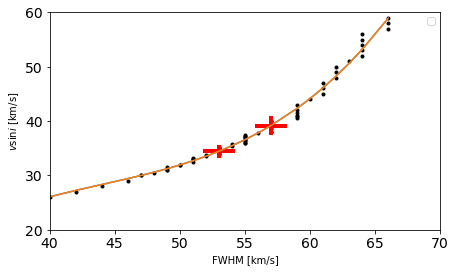

In [115]:
plt.figure(figsize=(7,4))

FWHM = corrf.apply(lambda x:np.where(x>np.max(x)/2.)[0][-1]-np.where(x>np.max(x)/2.)[0][0], axis=0)

plt.scatter(FWHM, FWHM.index.astype(float) , c="k", marker=".")

for i in salt:
    cc = corrsp[i]
    overhalf = np.where(cc>np.max(cc)/2.)[0]
    fwhm = overhalf[-1] - overhalf[0]
    print(np.argmin((FWHM-fwhm)**2), FWHM.index[np.argmin((FWHM-fwhm)**2)])
   # plt.axvline(fwhm)
    print(fwhm)
    x, y = FWHM.index.astype(float).values, FWHM.values
    x, y = FWHM.index.astype(float).values[25:], FWHM.values[25:]
    y0, ey0 = fwhm, lagunit.value


    z = np.polyfit(y,x,3)
    p = np.poly1d(z)

    pdiv = np.polyder(p)
    dfwhm_dvsini = pdiv(y0)
    yerr= dfwhm_dvsini * ey0
    x0, lox, upx = chisq(x,y,y0,ey0)
    plt.errorbar([y0],[p(y0)],xerr=ey0, yerr=yerr,c="r",linewidth=4)
    f = np.sort(FWHM[25:].values)
    plt.plot(f, p(f))
    
plt.ylim(20,60)
plt.xlim(40,70)
plt.xlabel("FWHM [km/s]")
plt.ylabel(r"$v\sin i$ [km/s]")
plt.legend();

In [98]:
x, y = FWHM.index.astype(float).values[25:], FWHM.values[25:]
y0, ey0 = fwhm, lagunit.value


z = np.polyfit(y,x,3)
p = np.poly1d(z)


0.7240893739426042

In [67]:
def chisq(x,y,y0,ey0):
    f = interpolate.interp1d(y, x, fill_value="extrapolate")
    x0, elox, eupx = float(f(y0)),f(y0-ey0),f(y0+ey0)
    
    return x0, x0-elox, eupx-x0

In [67]:
def sqmin(p):
    sq =  
    
    return x0, x0-elox, eupx-x0

In [68]:
chisq(x,y,y0,ey0)

(14.0, 1.1287348043899676, 0.38620441316990295)

old:

- Haalpha  vs. CN Leo: 35,25,55
- Halpha vs. M8norot: 40, 35, 50


- Rb extended (7938, 7955) vs. 2MUCD:41,44,47 (M8)
- Rb extended (7938, 7955) vs. CNLeo:35, 38, 38 (M6.5)
- Rb extended (7938, 7955) vs. Teegardens:35, 38, 32 (M7)
- Rb extended (7938, 7955) vs. LP731:35,41,41 (M6.5)
- Rb extended (7938, 7955) vs. V129:40,43,37 (M8)
- Rb extended (7938, 7955) vs. GJ1286:(M5.5)

- Na at 8195 vs. Teegardens: 80, 83,77
- Na at 8195 vs. CN Leo: 86, 89, 74

new:

- Rb extended (7938, 7955) vs. CNLeo: 34, 38
- Rb extended (7938, 7955) vs. LP731: 33, 38
- Rb extended (7938, 7955) vs. Teegarden's Star: 35, 37
- 7054 Jump vs LP731 :21,26
- 7054 Jump vs CN Leo :30,39
- 7054 Jump vs Teegarden's Star :39,56-62


In [27]:


user_dict = {"CN Leo (M6)":{1:34, 2:38, },
    "LP731 (M6.5)":{1:33,2:38,},
"Teegarden's Star (M7)":{1:35, 2:37}}

df=pd.DataFrame(user_dict).T
df.mean(axis=0), df.std(axis=0)

(1    34.000000
 2    37.666667
 dtype: float64,
 1    1.00000
 2    0.57735
 dtype: float64)

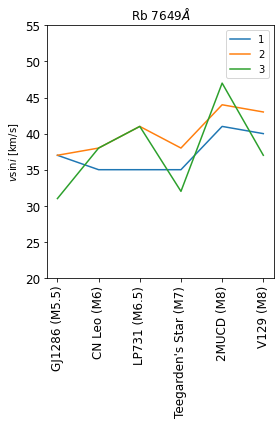

In [238]:
# # ms = [r"$m$","*","x","o"]
# # for label, row in df.iterrows():
# #     print(row.index, row.values)
# #     plt.scatter([row.index[0]]*3, row.values, s=200, marker= ms.pop(),label=label,)
# fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(4,6))
# df.plot(ax=ax)
# plt.legend(loc=(1))
# plt.ylim(20,55)
# plt.ylabel(r"$v\sin i$ [km/s]")
# plt.title(r"Rb $7649\AA$")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.savefig("../plots/vsini/Rb7649_cross_corr_various_stars.png", dpi=300)

In [339]:
salt.items()

dict_items([('TIC 44984200', [              lambd      flux  flux_err
0       3800.778493  0.000000  0.000000
1       3800.928310  0.000000  0.000000
2       3801.077975  0.000000  0.000000
3       3801.167701  0.000000  0.000000
4       3801.197598  0.000000  0.000000
...             ...       ...       ...
116069  8709.527901  0.004041  0.000001
116070  8709.558220  0.003687  0.000001
116071  8709.588532  0.003841  0.000001
116072  8709.618836  0.003655  0.000001
116073  8709.649133  0.004518  0.000001

[116063 rows x 3 columns], 'r']), ('TIC 277539431', [              lambd      flux  flux_err
0       3815.428078  0.000000  0.000000
1       3815.508939  0.000000  0.000000
2       3815.562817  0.000000  0.000000
3       3815.589748  0.000000  0.000000
4       3815.616673  0.000000  0.000000
...             ...       ...       ...
117461  8709.713681  0.004294  0.000001
117462  8709.744001  0.004415  0.000001
117463  8709.774313  0.004369  0.000001
117464  8709.804618  0.004186  0.000

In [131]:
2*(.7**2)

0.9799999999999999